# <center>Анализ результатов АБ-теста

В данной работе анализируются результаты АБ - теста по изменению поисковой страницы компании Яндекс. Следует подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами, определить характер этих изменений и практическую значимость вводимого изменения и понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения.

## Описание  данных

**userID**:  уникальный идентификатор пользователя

**browser**:  браузер, который использовал userID

**slot**: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)

**n_clicks**: количество кликов, которые пользоваль совершил за n_queries

**n_queries**: количество запросов, который совершил userID, пользуясь браузером browser

**n_nonclk_queries**: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обратим внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы.

В предлагаемых данных  уникальным является сочетание userID и browser.

Основная метрика, на которой следует сосредоточиться в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/ab_browser_test.csv')

In [3]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


## 1
Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе

In [4]:
n_clicks_slot = data\
                    .groupby('slot',as_index =False)\
                    .agg({'n_clicks':'sum'})    

In [5]:
print(np.round(((n_clicks_slot.iloc[1,1] - n_clicks_slot.iloc[0,1]) / n_clicks_slot.iloc[0,1])*100,3))


1.614


## 2
Посмотрим более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [6]:
np.random.seed(0)

In [7]:
# Функция, возвращающая бутстрапированные выборки
def get_bootstrap_samples(data, n_samples):
    indexes = np.random.randint(0,len(data),(n_samples, len(data)))
    samples = data[indexes]
    return samples

In [8]:
# Функция, которая считает доверительный интервал
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
n_clicks_exp = data.query("slot == 'exp'").n_clicks.values
n_clicks_con = data.query("slot == 'control'").n_clicks.values

In [10]:
# Средние
n_clicks_exp_means = np.mean(get_bootstrap_samples(n_clicks_exp, 1000), axis = 1)

In [11]:
n_clicks_con_means = np.mean(get_bootstrap_samples(n_clicks_con, 1000), axis = 1)

In [12]:
# Медианы
n_clicks_exp_medians = np.median(get_bootstrap_samples(n_clicks_exp, 1000), axis = 1)

In [13]:
n_clicks_con_medians = np.median(get_bootstrap_samples(n_clicks_con, 1000),axis = 1)

In [14]:
# Доверительный интервал для разности средних
stat_intervals (n_clicks_exp_means-n_clicks_con_means, 0.05)

array([0.19172563, 0.40475697])

In [15]:
# Доверительный интервал для разности медиан
stat_intervals (n_clicks_exp_medians-n_clicks_con_medians, 0.05)

array([1., 1.])

**95% доверительные интервалы для разности медиан и средних не  содержат ноль, похоже, отличия статистически значимы.**

## 2
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены средния значение и выборочная дисперсия

In [16]:
# Генерируем бустрапированные выборки, считаем среднее и стандартное отклонение
samples_con_means = np.mean(get_bootstrap_samples(n_clicks_con, 500),axis = 1)
samples_con_ssd = np.std(get_bootstrap_samples(n_clicks_con, 500),axis = 1)**2*500

qq-plot

(0.037476103375761, 11.279630825783507, 0.9989536033738181)

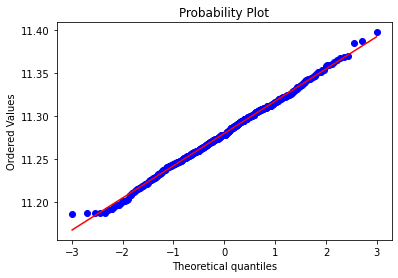

In [17]:
scipy.stats.probplot(samples_con_means, plot = plt)[1]

(105.94753757134862, 152872.82089349238, 0.9989421455948808)

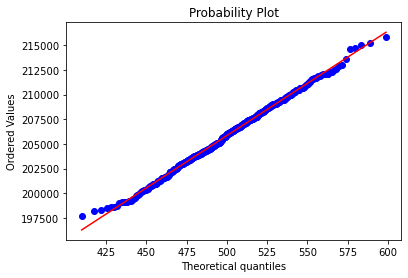

In [18]:
scipy.stats.probplot(samples_con_ssd, dist="chi2", 
                     sparams=(500-1), plot=plt)[1]

<AxesSubplot:ylabel='Density'>

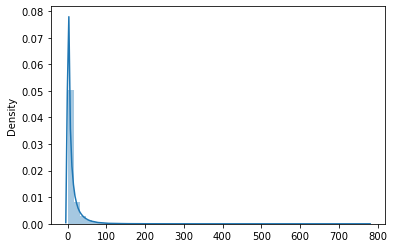

In [19]:
# Распределение количества кликов в экспериментальной группе
sns.distplot(n_clicks_exp)

<AxesSubplot:ylabel='Density'>

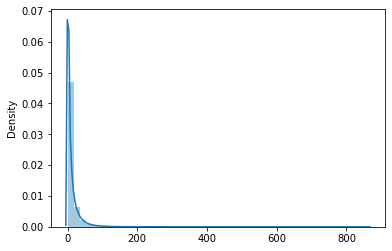

In [20]:
# Распределение количества кликов в контрольной группе
sns.distplot(n_clicks_con)

**Результаты на qq графиках демонстрируют, что среднее распределено нормально, несмещенная оценка дисперсии распределена по хи-квадрат, но не смотрят на это можно заметить, что данные сильно скошены, соответственно использование t-критерия не даст качественных результатов**

## 3
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделим выборку на две части, соответствующие control  и exp группам. Преобразуем данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверим гипотезу о равенстве средних.

In [21]:
data.head(2)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2


In [22]:
data['id'] = data.userID.astype('str') + data.browser

In [23]:
exp = data\
        .query("slot == 'exp'")\
        .groupby('id',as_index = False)\
        .agg({'n_clicks':'sum'})\
        .n_clicks\
        .values

In [24]:
con= data\
        .query("slot == 'control'")\
        .groupby('id',as_index = False)\
        .agg({'n_clicks':'sum'})\
        .n_clicks\
        .values

In [25]:
stats.mannwhitneyu(exp, con)

MannwhitneyuResult(statistic=38940590204.0, pvalue=3.1236179006848145e-75)

**Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между  двумя выборками**

## 4
Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделаем поправку Холма-Бонферрони на множественную проверку с α=0.05.

In [26]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,id
0,1,Browser #2,exp,23,32,19,1Browser #2
1,3,Browser #4,exp,3,4,2,3Browser #4
2,5,Browser #4,exp,29,35,16,5Browser #4
3,6,Browser #4,control,12,6,0,6Browser #4
4,7,Browser #4,exp,54,68,30,7Browser #4


In [27]:
exp = data\
        .query("slot == 'exp'")\
        .groupby('browser')\
        .agg({'n_clicks':'sum'})\
        .rename(columns = {'n_clicks':'n_clicks_exp'})\
        .n_clicks_exp\
        .to_frame()

In [28]:
con = data\
        .query("slot == 'control'")\
        .groupby('browser')\
        .agg({'n_clicks':'sum'})\
        .rename(columns = {'n_clicks':'n_clicks_con'})\
        .n_clicks_con\
        .to_frame()

In [29]:
hey = pd.merge(exp, con, on = 'browser')

In [30]:
hey

,n_clicks_exp,n_clicks_con
browser,,
Browser #14,294556,207229
Browser #17,266285,266732
Browser #2,560109,565964
Browser #20,223212,225897
Browser #22,858666,879810
Browser #4,1058995,1064395


In [31]:
browsers = [browser for browser in data.browser.unique()]

In [32]:
browsers

['Browser #2',
 'Browser #4',
 'Browser #14',
 'Browser #17',
 'Browser #20',
 'Browser #22']

In [33]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,id
0,1,Browser #2,exp,23,32,19,1Browser #2
1,3,Browser #4,exp,3,4,2,3Browser #4
2,5,Browser #4,exp,29,35,16,5Browser #4
3,6,Browser #4,control,12,6,0,6Browser #4
4,7,Browser #4,exp,54,68,30,7Browser #4


In [34]:
data_exp = data[data['slot'] == 'exp']
data_con = data[data['slot'] == 'control']

In [35]:
mw_df = pd.DataFrame(index = browsers,
                     columns = ['p_val_mw'])

In [36]:
for brow in browsers:
    exp = data_exp[data_exp['browser'] == brow].n_clicks.values
    con = data_con[data_con['browser'] == brow].n_clicks.values
    mw_df.loc[brow, 'p_val_mw'] = stats.mannwhitneyu(exp,con)[1]
    

In [37]:
mw_df['p_val_mw_hb'] = multipletests(mw_df['p_val_mw'], alpha = 0.05, method = 'fdr_bh')[1]

In [38]:
mw_df['p_val_mw_hb'] > 0.05

Browser #2      True
Browser #4      True
Browser #14    False
Browser #17     True
Browser #20     True
Browser #22     True
Name: p_val_mw_hb, dtype: bool

**Результаты демонстрируют, что для browser14 наиболее сильно выражены отличия в количестве кликов. Для него отвергается гипотеза о равенстве распределений.**

## 5
Для каждого браузера в каждой из двух групп (control  и exp) посчитаеем долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

In [39]:
data.head(2)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,id
0,1,Browser #2,exp,23,32,19,1Browser #2
1,3,Browser #4,exp,3,4,2,3Browser #4


In [40]:
data['dolya'] = data['n_nonclk_queries']/data['n_clicks']*100

In [41]:
dolya_exp = data\
    .query("slot == 'exp'")\
    .groupby('browser',as_index = False)\
    .agg({'n_queries':'sum','n_nonclk_queries':'sum'})
dolya_con = data\
    .query("slot == 'control'")\
    .groupby('browser',as_index = False)\
    .agg({'n_queries':'sum','n_nonclk_queries':'sum'})

In [42]:
dolya_exp['dolya_e_exp'] = (dolya_exp['n_nonclk_queries']/dolya_exp['n_queries'])*100
dolya_con['dolya_e_con'] = (dolya_con['n_nonclk_queries']/dolya_con['n_queries'])*100

In [43]:
doli = pd.merge(dolya_exp[['browser','dolya_e_exp']], dolya_con[['browser','dolya_e_con']], on = 'browser')

In [44]:
doli['dolya_e_exp'] < doli['dolya_e_con'] 

0     True
1    False
2     True
3     True
4     True
5     True
dtype: bool

In [45]:
doli

,browser,dolya_e_exp,dolya_e_con
0,Browser #14,43.755617,57.590411
1,Browser #17,36.937413,36.299367
2,Browser #2,44.982747,45.962747
3,Browser #20,38.977376,40.540485
4,Browser #22,39.853947,40.593977
5,Browser #4,45.142942,46.970930


**Результаты демонстрируют, что утверждение из прошлого пункта насчет пользователей, которые используют browser14, подтвердилось - после проведения эксперимента, процент некликнутых запросов заметно уменьшился. Для остальных же изменение незначительно (несколько процентов), что подтвеждают p-value из прошлого пункта.**

## Подведение итогов
Анализ результатов АБ-теста говорит о том, что изменения в поисковой странице браузера положительно сказались на поведении пользователей, количество кликов в среднем увеличилось, но, изучив показатели глубже, выяснился следующий факт: выигрывают только пользователи, использующие browser14 (только для них изменения статистически значимы), на остальных пользователей эксперимент никак не повлиял. Судить об успешности тяжело, с одной стороны можно выпустить в продакшн данное изменение только для пользователей, использующих browser14, но есть ли в этом большой смысл, если есть возможность изменить поисковую страницу так, чтобы изменения положительно сказались на всех пользователях, независимо от того, какой браузер они используют.